In [1]:
import math
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs

import os

In [4]:
# to get the node graph running
os.environ["PATH"] += os.pathsep + 'C:/Graphviz/bin/'

In [5]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

ModuleNotFoundError: No module named 'graphviz'

In [6]:
class Value() :
    def __init__(self, data=0, _children=(), _op='', label='') :
        self.data = data
        self.grad = 0 # stores the grad wrt output
        self._backward = lambda: None # stored the backward pass function
        self._prev = set(_children) # stores the children of the variable, to get the DAG
        self._op = _op # stores the operation from which this resulted
        self.label = label
    def __repr__(self) :
        return f'Value(data={self.data}) Label={self.label}' if self.label else f'Value(data={self.data})'
    def __neg__(self) :
        return -1*self
    def __add__(self, other) :
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward() :
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    def __radd__(self, other) : # if other+self does not work
        return self + other
    def __sub__(self, other) :
        return self + (-1*other)
    def __rsub__(self, other) :
        return -self + other
    def __mul__(self, other) :
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward() :
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
    def __rmul__(self, other) : # interchanging order of operands if not evaluable
        return self * other
    def __truediv__(self, other) :
        return self * other**-1
    def __rtruediv__(self, other) :
        return other * self**-1
    def __pow__(self, other) :
        assert isinstance(other, (int, float)) 
        val = self.data ** other
        out = Value(val, (self,), f'**{other}')
        def _backward() :
            self.grad += out.grad * other * (self.data ** (other-1)) # does not work if other==0,1
        out._backward = _backward
        return out
    def exp(self) :
        x = self.data
        val = math.exp(x)
        out = Value(val, (self,), 'exp')
        def _backward() :
            self.grad += val * out.grad
        out._backward = _backward
        return out
    def relu(self) :
        x = self.data
        t = x*int(x>0)
        out = Value(t, (self,), 'relu')
        def _backward() :
            self.grad += out.grad * int(t>0)
        out._backward = _backward
        return out
    def sigmoid(self) :
        x = self.data
        t = 1 / (1 + math.exp(-x))
        out = Value(t, (self,), 'sigm')
        def _backward() :
            self.grad = out.grad * t * (1-t)
        out._backward = _backward
        return out
    def tanh(self) :
        x = self.data
#         print(x)
#         t = (math.exp(2*x) - 1)/(math.exp(2*x)+1)
        t = math.tanh(x)
        out = Value(t, (self,), 'tanh')
        def _backward() :
            self.grad += out.grad * (1 - t**2)
        out._backward = _backward
        return out
    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

In [23]:
x1 = Value(2)
x2 = Value(5)
x3 = Value(1)
x4 = Value(1)
x5 = Value(0)
w11 = Value(-2)
w12 = Value(1)
w21 = Value(2)
w22 = Value(-1)

z1 = w11*x1 + w12*x2
z2 = w11*x2 + w12*x3
z3 = w11*x3 + w12*x4
z4 = w11*x4 + w12*x5

a1 = z1.relu()
a2 = z2.relu()
a3 = z3.relu()
a4 = z4.relu()

b1 = a1 
b2 = a3

out = w21*b1 + w22*b2
v = out.sigmoid()


In [24]:
v.backward()
mul = -1/v.data
w11.grad*mul, w12.grad*mul, w21.grad*mul, w22.grad*mul

(-0.47681168808847074, -1.1920292202211769, -0.11920292202211769, -0.0)

In [25]:
out.grad, w21.grad, 

(0.10499358540350662, 0.10499358540350662)

In [36]:
# creating a NN 
class Module :
    def zero_grad(self) :
        for p in self.parameters() :
            p.grad = 0
class Neuron(Module) :
    def __init__(self, ndim) :
        self.w = [Value(random.uniform(-1,1)) for _ in range(ndim)] # array of weights
        self.b = Value(random.uniform(-1,1)) # bias
    def __call__(self, x) :
        # wx + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.tanh() # only returns tanh activation for now
    def parameters(self) : # giving out list of all params
        return self.w + [self.b] # array of ndim+1 weights
class Layer(Module) :
    def __init__(self, nin, nout) : # nout is the number of neurons in the layer
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self,x) :
        return [n(x) for n in self.neurons]
    def parameters(self) :
        # returning each parameter for each neuron
        return [p for neuron in self.neurons for p in neuron.parameters()]
class MLP(Module) :
    def __init__(self, nin, nouts) : # nouts stores the number of neurons in each layer
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x) :
        for layer in self.layers :
            x = layer(x)
        return x
    def parameters(self) :
        return [p for layer in self.layers for p in layer.parameters()]

In [143]:
# My additions
# class Optimiser :
#     def __init__(self, params, lr=0.001) :
#         self.params = params
#         self.optim = optim
#         self.lr = lr
class SGD :
    def __init__(self, params, lr=0.001, momentum=0, weight_decay=0, dampening=0, nestrov=False) :
        assert 0<=momentum<=1
        self.params = params
        self.lr = lr
        self.momentum = momentum
        self.wt_decay = weight_decay # adds an L2 regularisation term, with the decay parameter acting as 2*lambda
        self.dampening = dampening # not well researched yet, supposed to help momentum
        self.nestrov = nestrov
        self.delta = 0
    def step(self) :
        for p in self.params :
            self.gt = p.grad
            self.gt += self.wt_decay*p.data 
            self.delta = self.momentum*self.delta + (1-self.dampening)*self.gt
            if self.nestrov : self.gt += self.momentum*self.delta 
            else : self.gt = self.delta
                
            p.data -= self.lr * self.gt
            


In [5]:
a = Value(3, label='a')
b = Value(-2, label='b')
c = Value(4, label='c')
d = a*b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(10, label='f')
L = e*f; L.label = 'L'

In [6]:
# simulating a neuron 
x1 = Value(2, label='x1')
x2 = Value(0, label='x1')

w1 = Value(-3, label='w1')
w2 = Value(1, label='w2')
b = Value(6.8, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'

s = x1w1+x2w2; s.label='s'

n = s+b; n.label = 'n'

o = n.tanh(); o.label='o'

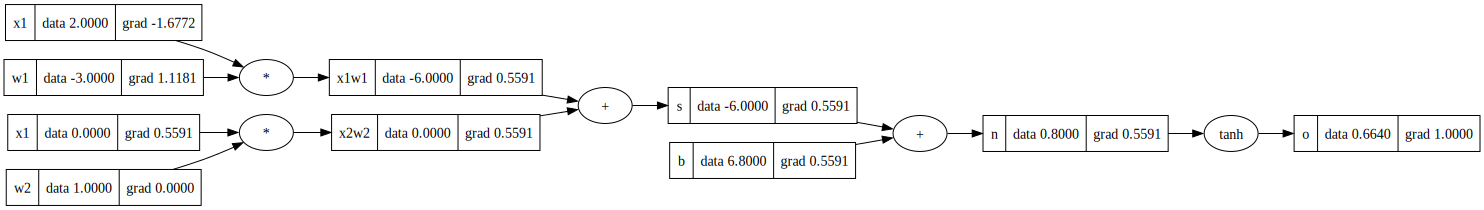

In [11]:
draw_dot(o)

In [10]:
o.backward()

In [12]:
# testing the MLP 
xs = [
    [2,3,-1],
    [3,-1,0.5],
    [0.5,1,1],
    [1,1,-1]
]
ys = [1,-1,-1,1]
losslog = []
a = MLP(3, [4,4,1])
for step in range(100) : # 100 epochs
    # forward pass
    ypred = [a(x)[0] for x in xs]
    loss = sum((ypred-ytrue)**2 for ytrue, ypred in zip(ys, ypred))
    losslog.append(loss)
    
    # backward pass
#     for w in a.parameters() :
#         w.grad = 0
    a.zero_grad() # taken from Module class
    loss.backward()
    
    # update 
    for w in a.parameters() :
        w.data -= 0.005 * w.grad

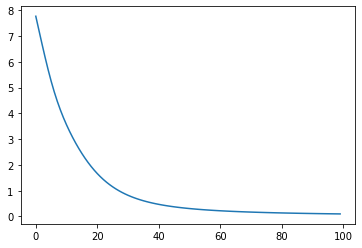

In [13]:
plt.plot([x.data for x in losslog])

In [14]:
[a(x)[0] for x in xs]

[Value(data=0.9030159619373817),
 Value(data=-0.8895100923147858),
 Value(data=-0.8234972662275828),
 Value(data=0.7979506397165885)]

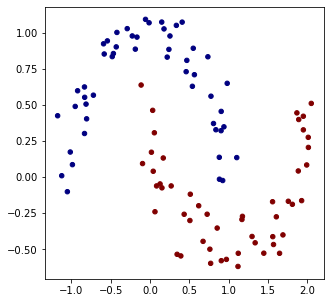

In [15]:
# testing the MLP class on a more complex example
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# # visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [16]:
model = MLP(2, [16, 16, 1]) # 2-layer neural network
# num_params = (2*16 + 16) + (16*16 + 16) + (16*1 + 1)
print(model)
print("number of parameters", len(model.parameters()))

number of parameters 337


In [17]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri] # batched input
    inputs = [list(map(Value, xrow)) for xrow in Xb] # = [Value(xrow) for xrow in xb] where xrow is a list
    
    # forward the model to get scores
    scores = list(map(model, inputs)) # = [model(input) for input in inputs]
    # svm "max-margin" loss
    losses = [(1 - yi*scorei[0]).relu() for yi, scorei in zip(yb, scores)] # hinge loss
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei[0].data > 0) for yi, scorei in zip(yb, scores)] # array of 1s and 0s
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.0168111425851873) 0.5


In [18]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
#     for p in model.parameters() :
#         p.grad = 0
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 1.0168111425851873, accuracy 50.0%
step 1 loss 1.012417948718542, accuracy 50.0%
step 2 loss 1.0100755027470663, accuracy 50.0%
step 3 loss 1.0060640736407933, accuracy 50.0%
step 4 loss 0.9913588085607327, accuracy 50.0%
step 5 loss 0.8293113972479741, accuracy 56.99999999999999%
step 6 loss 0.4934807749171818, accuracy 75.0%
step 7 loss 0.343836527252103, accuracy 85.0%
step 8 loss 0.3044462184895482, accuracy 87.0%
step 9 loss 0.25807359325764145, accuracy 89.0%
step 10 loss 0.23311610853615042, accuracy 90.0%
step 11 loss 0.22308148854024792, accuracy 92.0%
step 12 loss 0.21598316263938577, accuracy 92.0%
step 13 loss 0.2101937189612019, accuracy 92.0%
step 14 loss 0.20518760426577154, accuracy 92.0%
step 15 loss 0.20069282675254652, accuracy 92.0%
step 16 loss 0.19655528834165342, accuracy 92.0%
step 17 loss 0.19267764821538247, accuracy 92.0%
step 18 loss 0.18899001595559675, accuracy 93.0%
step 19 loss 0.18543604609554426, accuracy 93.0%
step 20 loss 0.18196507498655

(-1.618547804492727, 1.881452195507273)

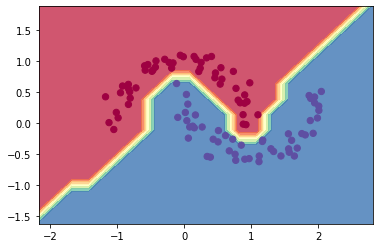

In [19]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h)) # gets x and y coordinates of a meshgrid
Xmesh = np.c_[xx.ravel(), yy.ravel()] # gets a list of coordinates (x,y)
inputs = [list(map(Value, xrow)) for xrow in Xmesh] # gets a list of inputs : coordinates in mesh
scores = list(map(model, inputs)) # gets the scores for each input
Z = np.array([s[0].data > 0 for s in scores]) # stores 0s and 1s corresponding to label predicted
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [660]:
# End of analysis :)

In [141]:
# My additions
# testing the optimiser class

# testing the MLP 
xs = [
    [2,3,-1],
    [3,-1,0.5],
    [0.5,1,1],
    [1,1,-1]
]
ys = [1,-1,-1,1]
losslog1 = []
losslog2 = []
a1 = MLP(3, [4,4,1]) # optimising without momentum
a2 = MLP(3, [4,4,1]) # optimising with momentum
# making the initializations same to enable comparison
for p1,p2 in zip(a1.parameters(), a2.parameters()) :
    p2.data = p1.data # initializaing with the same parameters
optim1 = SGD(a1.parameters(), lr=0.005)
optim2 = SGD(a2.parameters(), lr=0.005, momentum=0.5)
for step in range(100) : # 100 epochs
    # forward passes
    ypred = [a1(x)[0] for x in xs]
    loss1 = sum((ypred-ytrue)**2 for ytrue, ypred in zip(ys, ypred))
    losslog1.append(loss1)
    
    ypred = [a2(x)[0] for x in xs]
    loss2 = sum((ypred-ytrue)**2 for ytrue, ypred in zip(ys, ypred))
    losslog2.append(loss2)
    
    # backward passes
#     for w in a.parameters() :
#         w.grad = 0
    a1.zero_grad()
    loss1.backward()
    a2.zero_grad()
    loss2.backward()
    
    # update 
#     for w in a.parameters() :
#         w.data -= 0.005 * w.grad
    optim1.step()
    optim2.step()
    

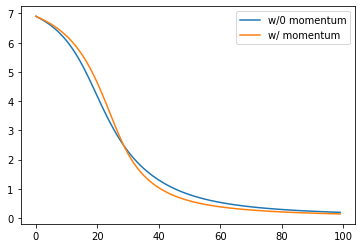

In [142]:
plt.plot([x.data for x in losslog1])
plt.plot([x.data for x in losslog2])
plt.legend(['w/0 momentum', 'w/ momentum'])

In [137]:
# showing the effect of momentum in action
wlog = []
blog = []
wlog2 = []
blog2 = []
lr = 0.01
mom = 0.5

w0 = -5.
b0 = 10.

def loss(w, b) : # constructing en elliptical loss function
    loss = 3*(w-2)**2 + (b-1)**2
    return loss

w = Value(w0, label='a')
b = Value(b0, label='b')
wlog.append(w.data)
blog.append(b.data)

for _ in range(20) :
    l = loss(w, b)
    
    w.grad, b.grad = 0,0
    l.backward()
    w.data -= lr * w.grad
    b.data -= lr * b.grad
    wlog.append(w.data)
    blog.append(b.data)
    
# WITH MOMENTUM

w = Value(w0, label='a')
b = Value(b0, label='b')
wlog2.append(w.data)
blog2.append(b.data)

for _ in range(30) :
    l = loss(w, b)
    
    w.grad, b.grad = 0,0
    l.backward()
    if _ == 0 :
        wdel = w.grad
        bdel = b.grad
    else :
        wdel = mom*wdel + w.grad
        bdel = mom*bdel + b.grad
    w.data -= lr * wdel
    b.data -= lr * bdel
    wlog2.append(w.data)
    blog2.append(b.data)


In [138]:
# final losses
print(loss(wlog[-1], blog[-1]))
print(loss(wlog2[-1], blog2[-1]))

48.47349249811065
6.901258860665083


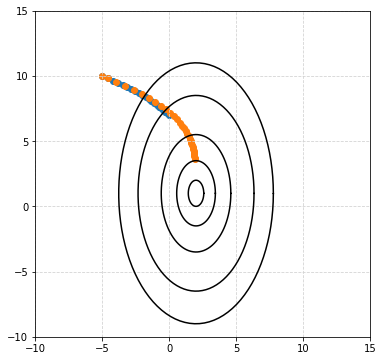

In [139]:
u=2.     #x-position of the center
v=1.    #y-position of the center
b=np.array([1,2.5, 4.5, 7.5, 10])     #radius on the x-axis
a=b/(3**0.5)    #radius on the y-axis

t = np.linspace(0, 2*3.14, 100)
plt.figure(figsize=(6,6))
for x,y in zip(a,b) :
    plt.plot( u+x*np.cos(t) , v+y*np.sin(t), color='black')
plt.grid(color='lightgray',linestyle='--')
plt.scatter(x=wlog, y=blog, label='w/o momentum')
plt.scatter(x=wlog2, y=blog2, label='w/ momentum')
plt.xlim([-10, 15])
plt.ylim([-10,15])
plt.show()

In [62]:
a1.parameters()

[Value(data=-0.39899262412539094), Value(data=0.9261434029836142)]

In [59]:
xs = [
    [2],
    [3],
    [0.5],
    [1]
]
ys = [2*x[0]+1 for x in xs]

In [60]:
ys

[5, 7, 2.0, 3]

In [58]:
xs[0]

[2]

In [46]:
a1.parameters()[0].data += 1

In [47]:
a1.parameters()

[Value(data=1.9074271513218444),
 Value(data=-0.3109813448272196),
 Value(data=0.9065185172734642),
 Value(data=-0.030963505807057867)]

In [48]:
a2.parameters()

[Value(data=0.9074271513218444),
 Value(data=-0.3109813448272196),
 Value(data=0.9065185172734642),
 Value(data=-0.030963505807057867)]